# Flood Stats
- Data: Gauge, Discharge, Rainfall
- STIDs: RA101 and RA107 with a focus on RA107

## Goals
10/31 Meeting
- Clean data
- Get daily max values (creek values)
- Separate into 3 levels:
    - Minor flood stage: 8.5 ft
    - Moderate flood stage: 9.5 ft
    - Major flood stage: 11 ft
    - Minimum operating limit: 0.5 ft

## Data Dictionary
- date: date of measurement
- hour: hour of measurement
- stid: standard id; regional location
- gauge: water level in feet
- discharge: discharge level in cubic feet per second
- rainfall: rainfall level in inches
- rainfall_ft: rainfall level in feet

### Data Sources
- [Gauge and Discharge](https://waterdata.usgs.gov/monitoring-location/01464000/#parameterCode=00060&startDT=2005-10-01&endDT=2022-10-18)
- [Rainfall](https://njdep.rutgers.edu/rainfall/)

### Setup

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [39]:
# Setup
plt.rcParams["figure.figsize"] = (16, 8)
plt.figure(dpi=1000)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

<Figure size 16000x8000 with 0 Axes>

In [2]:
# Display entire dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
combined = pd.read_csv("Data/combined_rainfall_discharge_gauge.csv")
combined = combined[["Date", "StID_y", "discharge", "guage", "rainfall_107"]]

### Data Cleaning and Manipulation

In [4]:
combined.columns = combined.columns.str.lower()
combined = combined.rename(columns={'guage': 'gauge', 'rainfall_107': 'rainfall_inches', 'stid_y':'stid'})
combined.head()

,date,stid,discharge,gauge,rainfall_inches
0,2007-10-01,RA107,23.2,2.39,0.0
1,2007-10-01,RA107,22.6,2.38,0.0
2,2007-10-01,RA107,21.9,2.37,0.0
3,2007-10-01,RA107,20.6,2.35,0.0
4,2007-10-01,RA107,18.9,2.32,0.0


In [5]:
combined['rainfall_ft'] = round(combined['rainfall_inches']/12, 2)
combined['date'] = pd.to_datetime(combined['date'], infer_datetime_format=True)

In [6]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131199 entries, 0 to 131198
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   date             131199 non-null  datetime64[ns]
 1   stid             131199 non-null  object        
 2   discharge        131199 non-null  float64       
 3   gauge            131199 non-null  float64       
 4   rainfall_inches  131199 non-null  float64       
 5   rainfall_ft      131199 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 6.0+ MB


In [7]:
combined.isnull().sum()

date               0
stid               0
discharge          0
gauge              0
rainfall_inches    0
rainfall_ft        0
dtype: int64

### Descriptive Stats + Correlational Analysis

In [8]:
combined.describe()

,discharge,gauge,rainfall_inches,rainfall_ft
count,131199.000000,131199.000000,131199.000000,131199.000000
mean,160.276956,3.242591,0.005937,0.000388
std,213.167199,0.758934,0.036788,0.003111
min,10.100000,2.170000,0.000000,0.000000
25%,58.400000,2.770000,0.000000,0.000000
50%,103.000000,3.080000,0.000000,0.000000
75%,179.000000,3.470000,0.000000,0.000000
max,5820.000000,15.120000,2.060000,0.170000


In [9]:
combined.corr()

,discharge,gauge,rainfall_inches,rainfall_ft
discharge,1.000000,0.951102,0.162009,0.150434
gauge,0.951102,1.000000,0.169425,0.155534
rainfall_inches,0.162009,0.169425,1.000000,0.968311
rainfall_ft,0.150434,0.155534,0.968311,1.000000


### Group data to get max levels for each day

In [10]:
daily_max = combined.groupby(by='date').max().reset_index()
daily_max.head()

,date,stid,discharge,gauge,rainfall_inches,rainfall_ft
0,2007-10-01,RA107,23.9,2.40,0.0,0.0
1,2007-10-02,RA107,23.2,2.39,0.0,0.0
2,2007-10-03,RA107,23.2,2.39,0.0,0.0
3,2007-10-04,RA107,23.2,2.39,0.0,0.0
4,2007-10-05,RA107,25.2,2.42,0.0,0.0


In [11]:
daily_max.describe()

,discharge,gauge,rainfall_inches,rainfall_ft
count,5477.000000,5477.000000,5477.000000,5477.000000
mean,218.041172,3.464241,0.052102,0.004019
std,304.062274,0.998043,0.131999,0.011183
min,17.000000,2.320000,0.000000,0.000000
25%,69.300000,2.850000,0.000000,0.000000
50%,123.000000,3.190000,0.000000,0.000000
75%,242.000000,3.740000,0.040000,0.000000
max,5820.000000,15.120000,2.060000,0.170000


In [28]:
def segment_floods(lower, upper=None):
	if upper is None:
		filter = np.where(daily_max['gauge'] >= lower)
	else:
		filter = np.where((daily_max['gauge'] >= lower) & (daily_max['gauge'] < upper))

	return filter

In [29]:
op_limit = segment_floods(0.5)
minor_filter = segment_floods(8.5, 9.5)
moderate_filter = segment_floods(9.5, 11)
major_filter = segment_floods(11)

In [30]:
filters = [minor_filter, moderate_filter, major_filter]
labels = ['Minor', 'Moderate', 'Major']

In [33]:
# Assign flood label values
for filter, label in zip(filters, labels):
	for idx in filter:
		daily_max.loc[idx, 'category'] = label

daily_max['category'].unique()

array(['Not Flood', 'Minor', 'Moderate', 'Major'], dtype=object)

### Data Visualization

<AxesSubplot:xlabel='date', ylabel='gauge'>

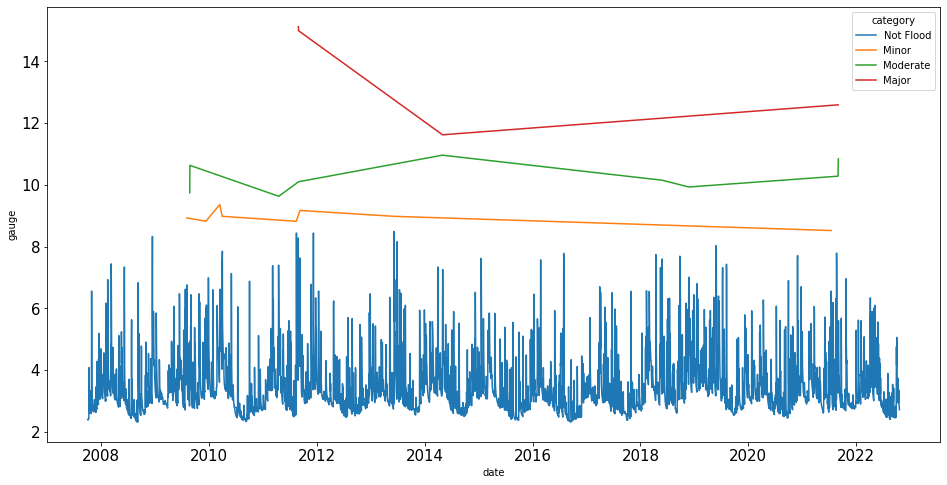

In [41]:
all = sns.lineplot(x='date', y='gauge', hue='category', data=daily_max)
all

<AxesSubplot:xlabel='date', ylabel='gauge'>

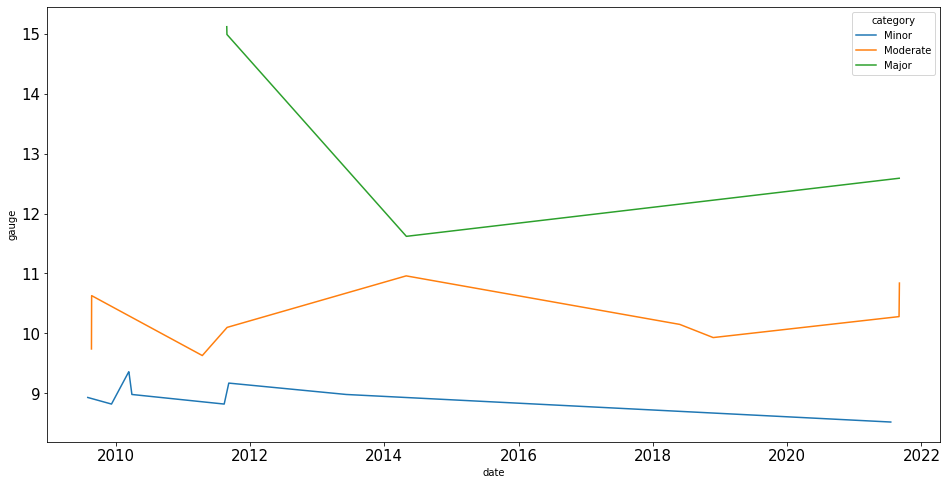

In [43]:
floods = sns.lineplot(x='date', y='gauge', hue='category', data=daily_max[daily_max['gauge'] >= 8.5])
floods